In [1]:
# init.py
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc
import tenseal as ts  # <<< THÊM VÀO

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa

# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

# <<< THÊM VÀO: Khởi tạo Homomorphic Encryption Context >>>
print("Đang tạo HE context...")
he_context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
he_context.generate_galois_keys()
he_context.global_scale = 2**40
# Chia sẻ context public cho server, client sẽ giữ private key
he_context_serialized = he_context.serialize(save_secret_key=False) 
print("Đã tạo xong HE context.")
# <<< KẾT THÚC THÊM VÀO >>>


input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_multi import Server
from client_multi import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

# <<< CHỈNH SỬA: Thêm he_context khi khởi tạo Client >>>
clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list,
                                     he_context=he_context) # TRUYỀN HE CONTEXT VÀO
                 for clientID, client_name in enumerate(active_clients_list)}
# <<< KẾT THÚC CHỈNH SỬA >>>


temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()
    client.close()  # Đóng Dask Client sau khi hoàn tất

2025-06-25 01:59:49.704601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 01:59:49.715206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750791589.724964  133199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750791589.728505  133199 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750791589.736764  133199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:36709' processes=2 threads=4, memory=7.45 GiB>
Đang tạo HE context...
Đã tạo xong HE context.
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP              

I0000 00:00:1750791595.128650  133199 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/2
Epoch 1/2
Epoch 1/2


I0000 00:00:1750791598.714569  133324 service.cc:152] XLA service 0x7f82680030f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750791598.714956  133324 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1750791598.736789  133319 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750791598.900023  133321 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-25 02:00:02.924484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


4495/5338 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9025 - loss: 0.2713

2025-06-25 02:00:38.731566: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-25 02:00:38.846634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



4598/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9032 - loss: 0.2690

2025-06-25 02:00:39.452158: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



4616/5338 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9033 - loss: 0.2687

2025-06-25 02:00:39.663707: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4881/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9051 - loss: 0.2633

2025-06-25 02:00:40.981462: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-25 02:00:41.039173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-25 02:00:41.061379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



4991/5338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9058 - loss: 0.2612

2025-06-25 02:00:41.551704: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



5055/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2600

2025-06-25 02:00:42.050130: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-25 02:00:42.148706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



5269/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9074 - loss: 0.2563

2025-06-25 02:00:43.053693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads



5279/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9075 - loss: 0.2561

2025-06-25 02:00:42.645589: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-25 02:00:42.780246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads

2025-06-25 02:00:43.349735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads

2025-06-25 02:00:43.477733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-25 02:00:43.755945: I external/l

4262/4262 ━━━━━━━━━━━━━━━━━━━━ 96s 20ms/step - accuracy: 0.8995 - loss: 0.2816 - val_accuracy: 0.9494 - val_loss: 0.1244
Epoch 2/2
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms/step - accuracy: 0.9001 - loss: 0.2868 - val_accuracy: 0.9496 - val_loss: 0.1236
Epoch 2/2
 895/4262 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9492 - loss: 0.1292

2025-06-25 02:01:35.822207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-25 02:01:35.908758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 469/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9472 - loss: 0.1334

2025-06-25 02:01:36.388390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads

2025-06-25 02:01:36.554392: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1378/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9493 - loss: 0.1288

2025-06-25 02:01:38.366144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 72 bytes spill stores, 72 bytes spill loads

2025-06-25 02:01:38.409500: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 384 bytes spill stores, 384 bytes spill loads



 918/3739 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9477 - loss: 0.1324

2025-06-25 02:01:38.687432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 808 bytes spill stores, 716 bytes spill loads



1447/4262 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9494 - loss: 0.1287

2025-06-25 02:01:39.057350: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5338/5338 ━━━━━━━━━━━━━━━━━━━━ 104s 18ms/step - accuracy: 0.9078 - loss: 0.2551 - val_accuracy: 0.9516 - val_loss: 0.1178
Epoch 2/2
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9485 - loss: 0.1303 - val_accuracy: 0.9540 - val_loss: 0.1129
2758/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9500 - loss: 0.1265Done model fit

2765/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9500 - loss: 0.1265

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2766/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9500 - loss: 0.1265[client_1] Bắt đầu mã hóa tham số...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[client_1] Mã hóa hoàn tất.
client_1 End Produce Weights
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9498 - loss: 0.1271 - val_accuracy: 0.9521 - val_loss: 0.1172
2845/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9501 - loss: 0.1265Done model fit

2853/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9501 - loss: 0.1265[client_2] Bắt đầu mã hóa tham số...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
[client_2] Mã hóa hoàn tất.
client_2 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-25 02:02:09.871234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 384 bytes spill stores, 384 bytes spill loads

2025-06-25 02:02:09.997237: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 72 bytes spill stores, 72 bytes spill loads



  2/702 ━━━━━━━━━━━━━━━━━━━━ 12:23 1s/step - accuracy: 0.9516 - loss: 0.1073

2025-06-25 02:02:10.257986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_122', 808 bytes spill stores, 716 bytes spill loads



702/702 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9528 - loss: 0.1153
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9532 - loss: 0.1142
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9537 - loss: 0.1108
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4431 - loss: 1.1628
Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.9532238245010376 
local loss: 0.11494169384241104 
global accuracy: 0.44349297881126404 
global_loss: 1.1622437238693237 
local compute time: 0:01:57.937254 
Simulated time to receive global weights: 0:02:08.624170 
 

800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3113 - loss: 1.2187
Arguments:  Performance Metrics for client_2 on iteration 1 
------------------------------------------- 
local accuracy: 0.9530974626541138 
local loss: 0.11490549892187119 
global accuracy: 0.3102186322212219 
global_loss: 1.218899130821228 
local compute time: 0:01:58.8815

In [2]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Giả định các biến global như tempdirs, active_clients_list, test_gens, stepsTest_Clients đã được định nghĩa
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

# Tự động xác định số iteration cho từng client
model_names_template = [f"global_model_iter_{i+1}.keras" for i in range(8)]  # Danh sách tiềm năng
actual_iterations = {}
for i, client_dir in enumerate(tempdirs):
    existing_models = [m for m in model_names_template if os.path.exists(client_dir + m)]
    if existing_models:
        current_max = max([int(m.split('_')[-1].split('.')[0]) for m in existing_models])
        actual_iterations[f'client_{i}'] = current_max
    else:
        actual_iterations[f'client_{i}'] = 8  # Mặc định 8 nếu không tìm thấy tệp
model_names = {f'client_{i}': [f"global_model_iter_{j}.keras" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
Iterations = {f'client_{i}': [f"Iteration {j}" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
print(f"Detected iterations: {actual_iterations}")

# Load models
models = {}
for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i] + model_name) for model_name in model_names[client_name]]
print(models['client_0'])

Detected iterations: {'client_0': 8, 'client_1': 8, 'client_2': 8}


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 34 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-06-25 02:12:05.975670: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


517969
<Sequential name=sequential, built=True>


2025-06-25 02:12:06.290257: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-06-25 02:12:06.979617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-25 02:12:07.012209: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 02:12:07.019918: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 292 bytes spill stores, 292 bytes spill loads

2025-06-25 02:12:07.030507: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation

16143/16187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-25 02:12:25.353468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2025-06-25 02:12:25.385772: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 16 bytes spill stores, 16 bytes spill loads

2025-06-25 02:12:25.443517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 272 bytes spill stores, 272 bytes spill loads

2025-06-25 02:12:25.699812: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 384 bytes spill stores, 384 bytes spill loads



16187/16187 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16187/16187 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Precision Score:  [0.5793697224349008, 0.8914651687366231, 0.8995172733326331, 0.8970936375778955, 0.8972052834250004, 0.9020127357783639, 0.9046328641267195, 0.9019107481045096]
Recall Score:  [0.23202210412334337, 0.8237984344173288, 0.8326336522823077, 0.8406653976061108, 0.8421880987124906, 0.8425292254205401, 0.8433864897170278, 0.8474543

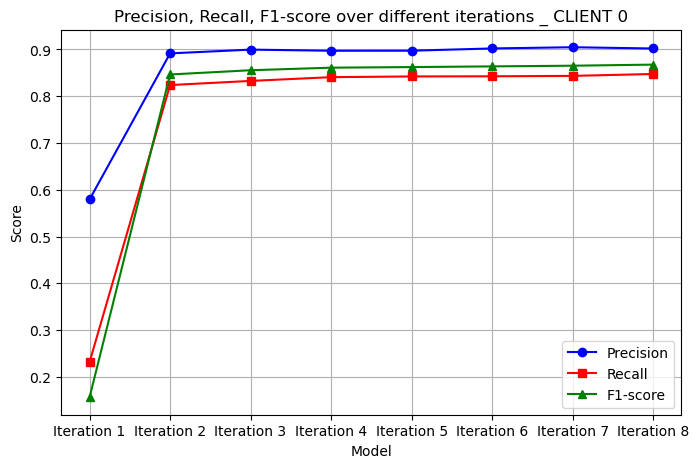

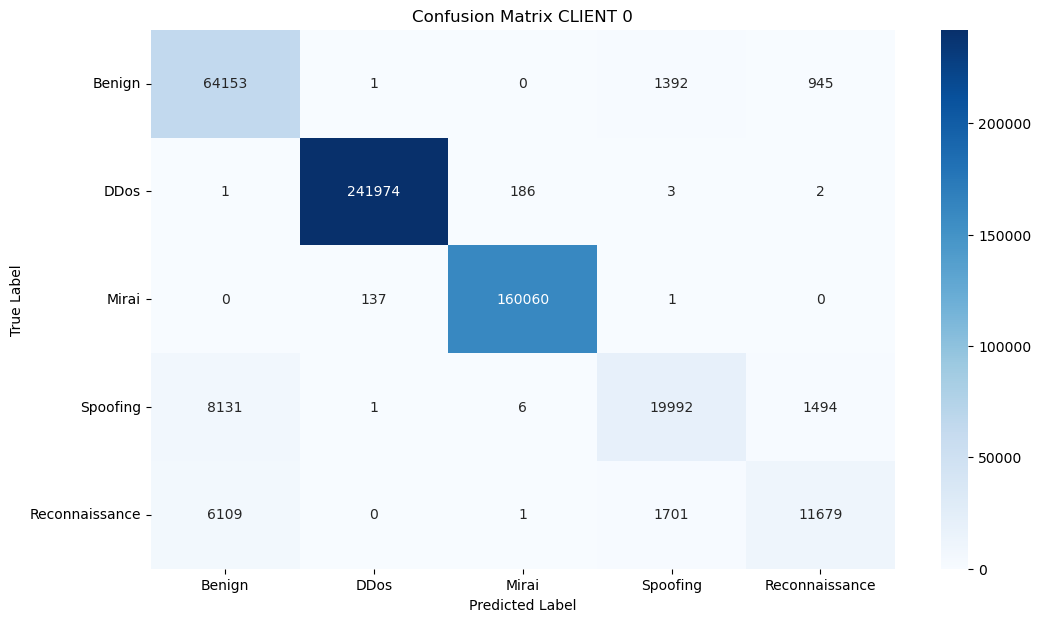

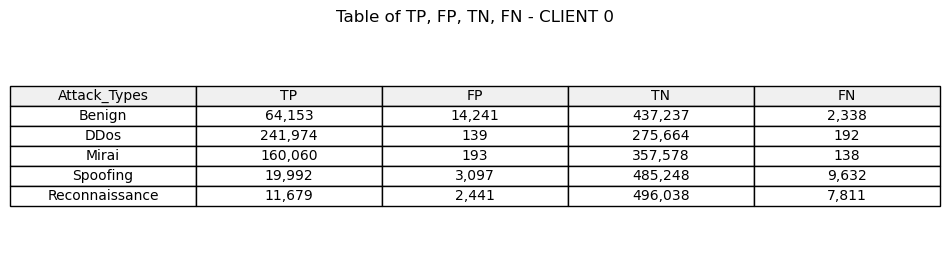

/tmp/ipykernel_133199/3875102694.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


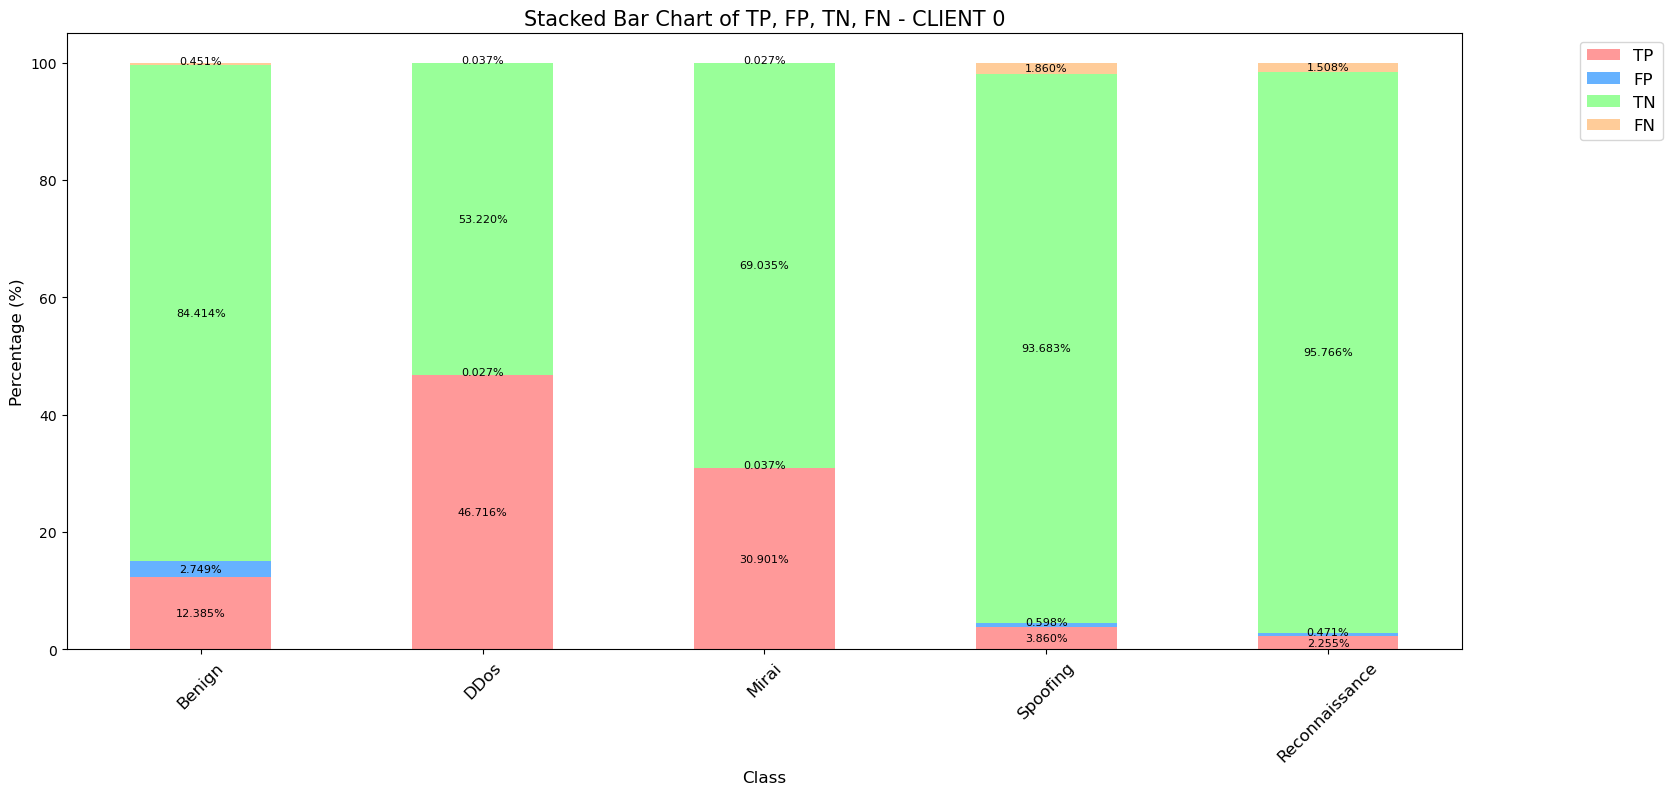

In [3]:
# Client 0
precisions = []
recalls = []
f1s = []

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(actual_iterations['client_0']):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)

# Vẽ biểu đồ Precision, Recall, F1-score
plt.figure(figsize=(8, 5))
plt.plot(Iterations['client_0'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations['client_0'], recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations['client_0'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.grid(True)
plt.savefig(tempdirs[0] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()

attack_types = ['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")
plt.savefig(tempdirs[0] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính và vẽ TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 0")
#plt.tight_layout(pad=0.5)
plt.savefig(tempdirs[0] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(18, 8))
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            y_pos = bottom[i] + height / 2
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,
                    fontsize=8, color="black")
    bottom += df_metrics[metric]

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 0", fontsize=15)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
#plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

2025-06-25 02:14:48.896851: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


362251
<Sequential name=sequential_1, built=True>
11291/11321 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-25 02:15:02.398989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 128 bytes spill stores, 128 bytes spill loads

2025-06-25 02:15:02.407977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads



11321/11321 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_1, built=True>
11321/11321 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Precision Score Client 1:  [0.5727264135425345, 0.8883945218488616, 0.8948065635613555, 0.8984086163614785, 0.8965494519160769, 0.8988862862983475, 0.8949672479824461, 0.8954933741414426]
Recall Score Client 1:  [0.30377725702451797, 0.8285328876959464, 0.8380697795676804, 0.8364177319964463, 0.837209065607845, 0.8439216840840056

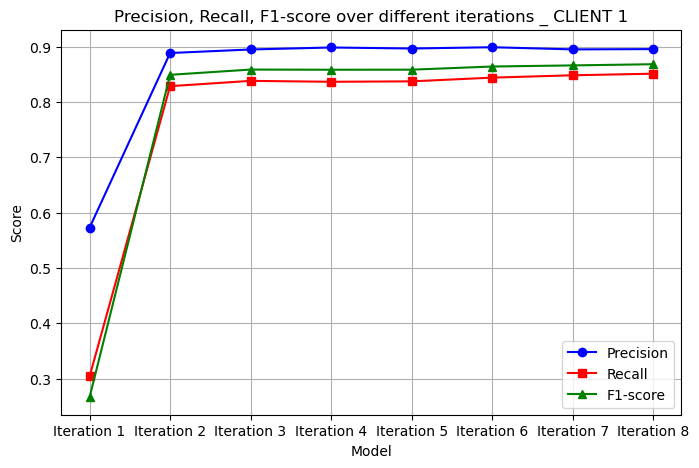

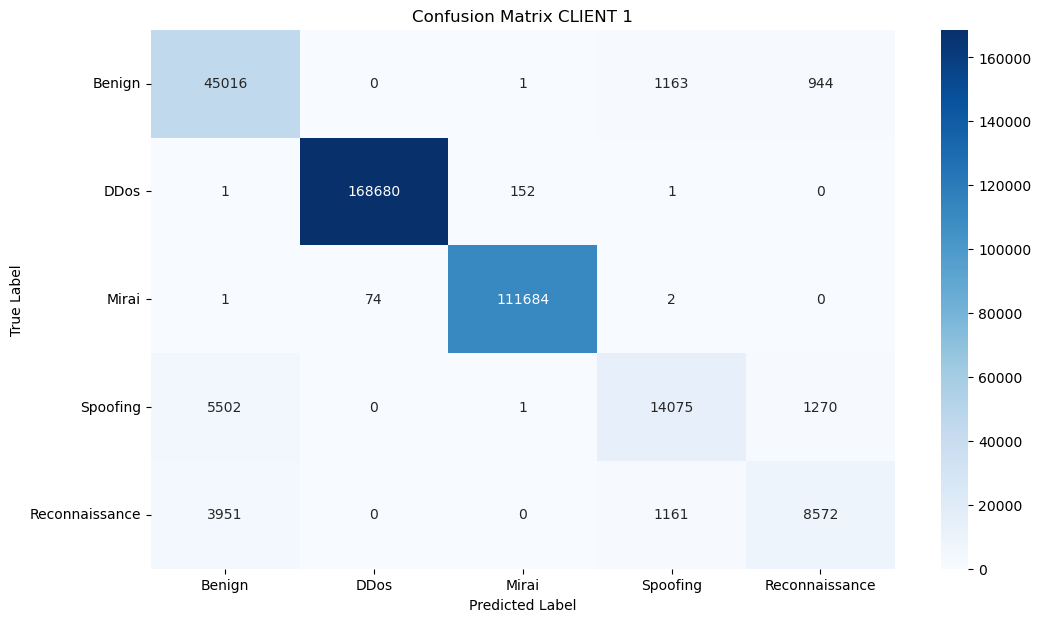

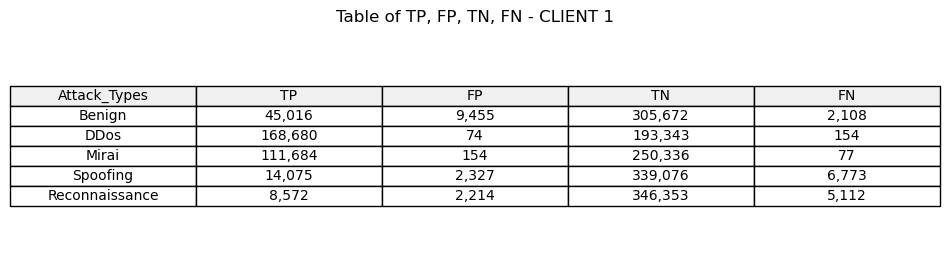

/tmp/ipykernel_133199/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


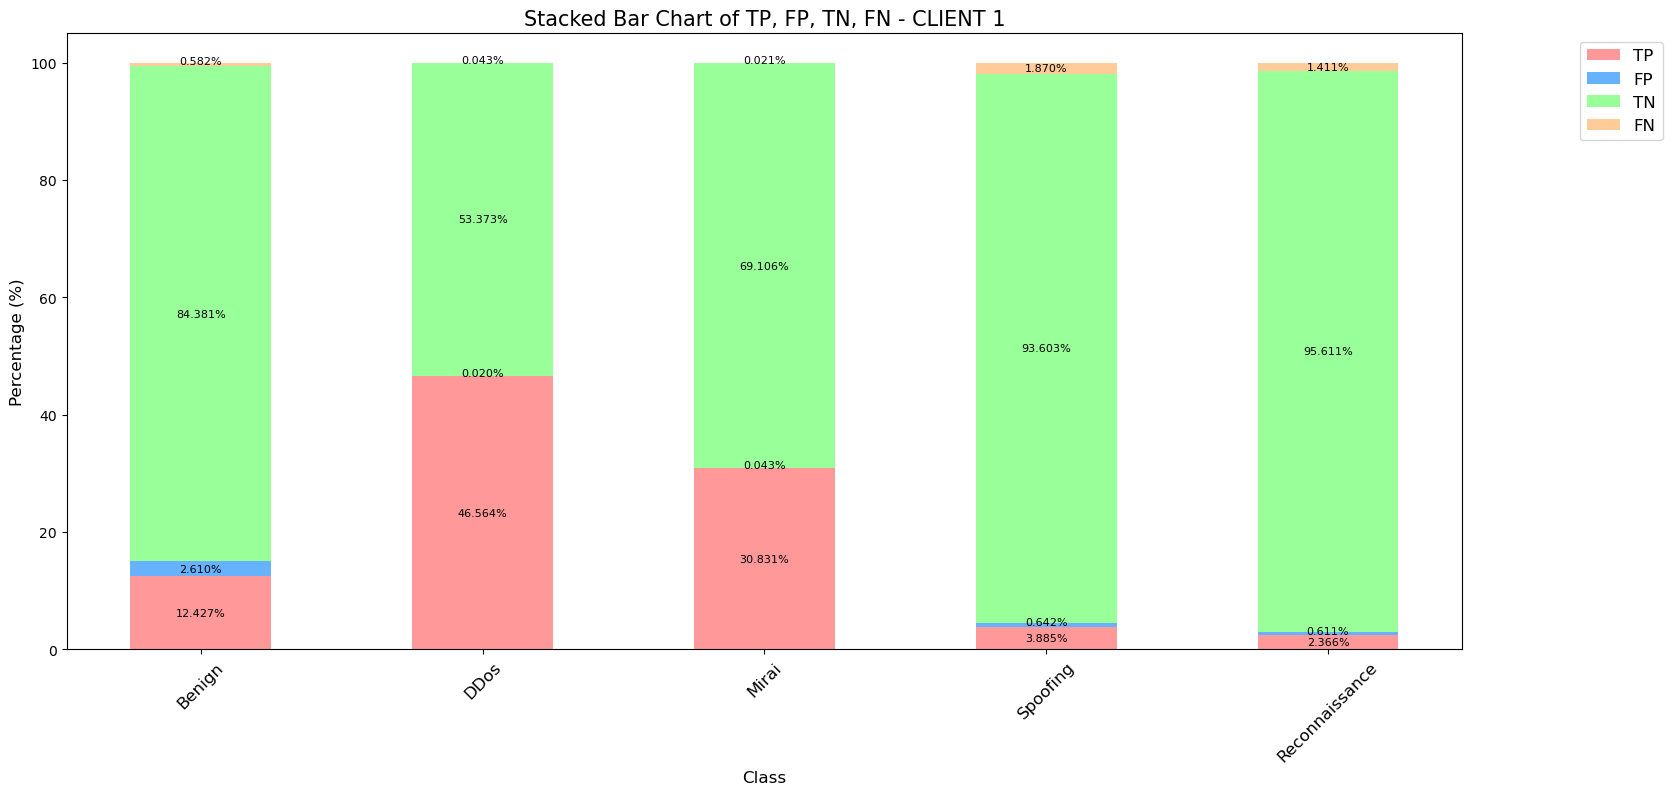

413966
<Sequential name=sequential_2, built=True>
12909/12937 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-06-25 02:17:00.809971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 384 bytes spill stores, 384 bytes spill loads

2025-06-25 02:17:00.940283: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 128 bytes spill stores, 128 bytes spill loads



12937/12937 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
<Sequential name=sequential_2, built=True>
12937/12937 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Precision Score Client 2:  [0.24975216988521948, 0.8934162011887669, 0.9017738911856423, 0.9006238366769471, 0.8948217261169216, 0.8950189474926761, 0.8987121540873193, 0.8989482985444756]
Recall Score Client 2:  [0.2049602657188913, 0.8236644256402824, 0.8327844585411988, 0.8367986980935168, 0.8466772068300404, 0.850660289417440

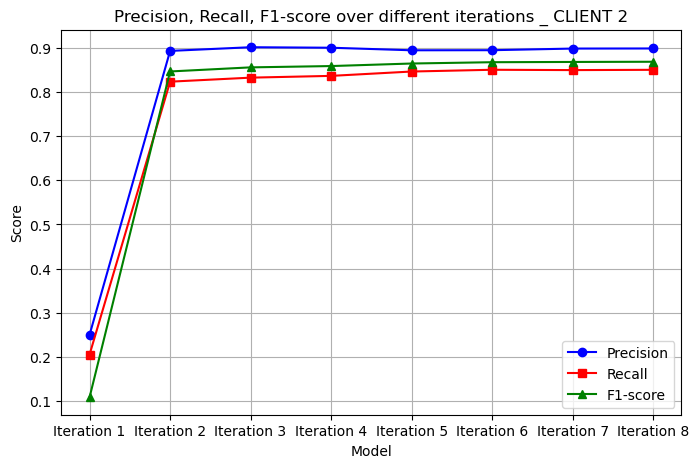

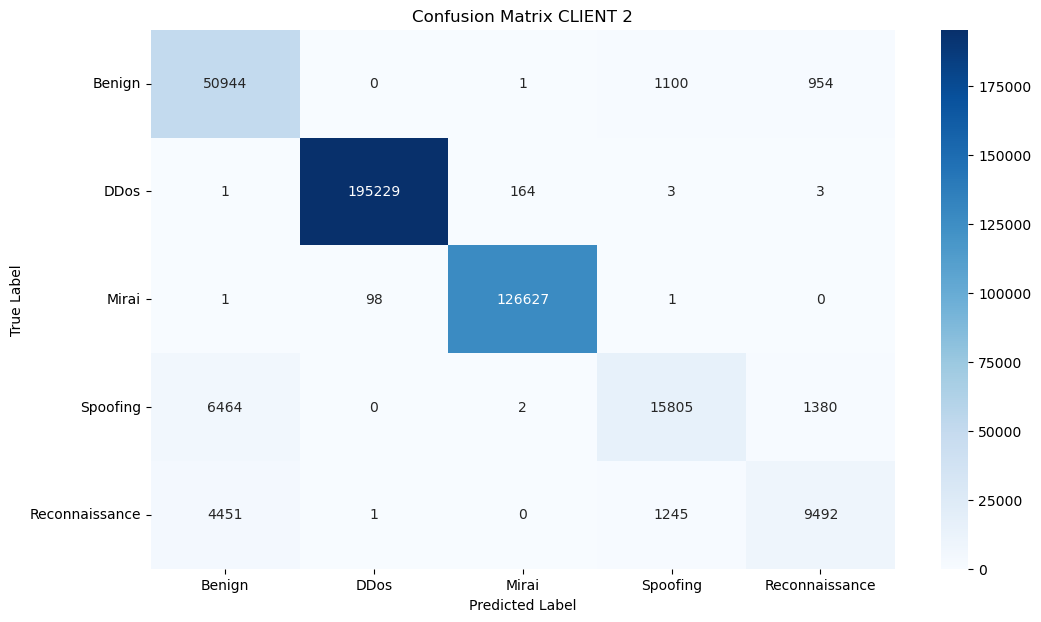

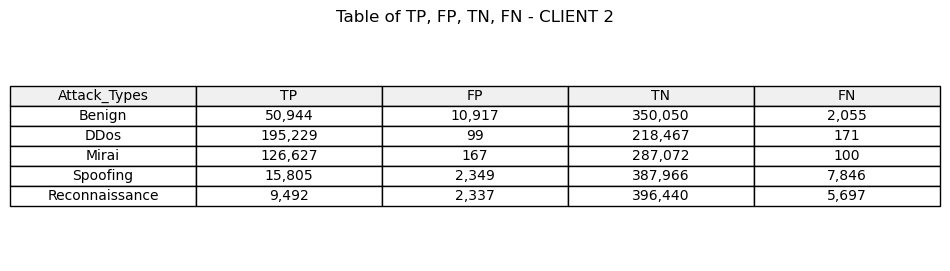

/tmp/ipykernel_133199/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


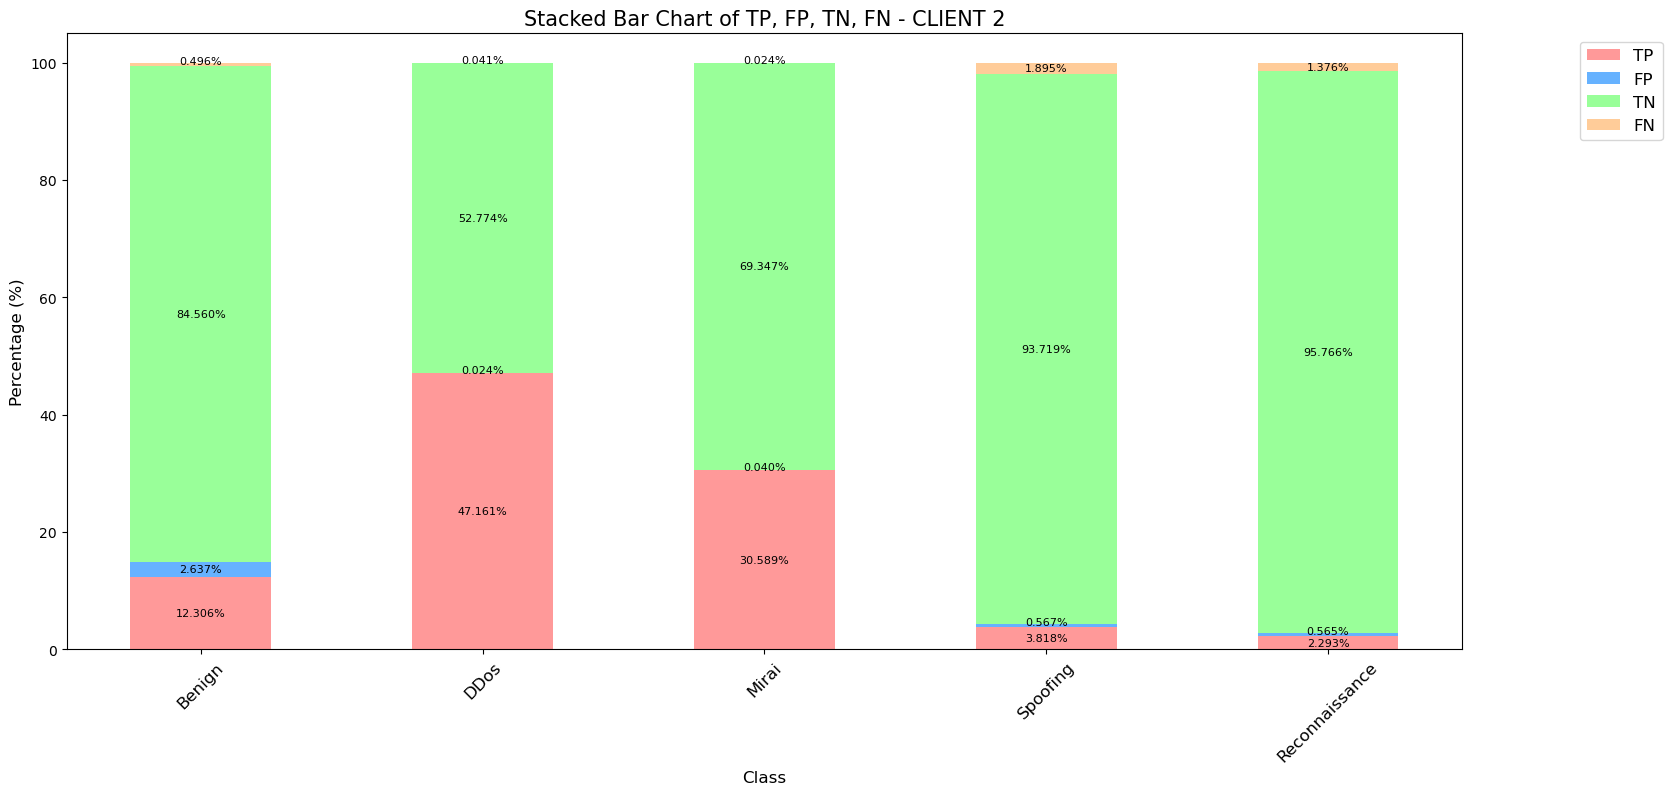

In [4]:
# Lặp cho Client 1 và Client 2
for client_idx in [1, 2]:
    precisions = []
    recalls = []
    f1s = []

    X_test = []
    y_test = []
    for X_batch, y_batch in test_gens[client_idx].take(stepsTest_Clients[client_idx]):
        X_test.append(X_batch.numpy())
        y_test.append(y_batch.numpy())
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    print(len(X_test))
    for iteration in range(actual_iterations[f'client_{client_idx}']):
        print(models[f'client_{client_idx}'][iteration])
        y_pred_pre = models[f'client_{client_idx}'][iteration].predict(X_test, verbose=1)
        y_pred = np.argmax(y_pred_pre, axis=1)
        
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
    print(f"Precision Score Client {client_idx}: ", precisions)
    print(f"Recall Score Client {client_idx}: ", recalls)
    print(f"F1 Score Client {client_idx}: ", f1s)

    # Vẽ biểu đồ Precision, Recall, F1-score
    plt.figure(figsize=(8, 5))
    plt.plot(Iterations[f'client_{client_idx}'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
    plt.plot(Iterations[f'client_{client_idx}'], recalls, marker='s', linestyle='-', label="Recall", color='red')
    plt.plot(Iterations[f'client_{client_idx}'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, F1-score over different iterations _ CLIENT {client_idx}")
    plt.legend()
    plt.grid(True)
    plt.savefig(tempdirs[client_idx] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix CLIENT {client_idx}")
    plt.savefig(tempdirs[client_idx] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

    metrics = []
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])

    df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title(f"Table of TP, FP, TN, FN - CLIENT {client_idx}")
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()

    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100

    fig, ax = plt.subplots(figsize=(18, 8))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]

    ax.set_xlabel("Class", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"Stacked Bar Chart of TP, FP, TN, FN - CLIENT {client_idx}", fontsize=15)
    ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
    ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()


Log files: {'client_0': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv'], 'client_1': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv'], 'client_2': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv']}


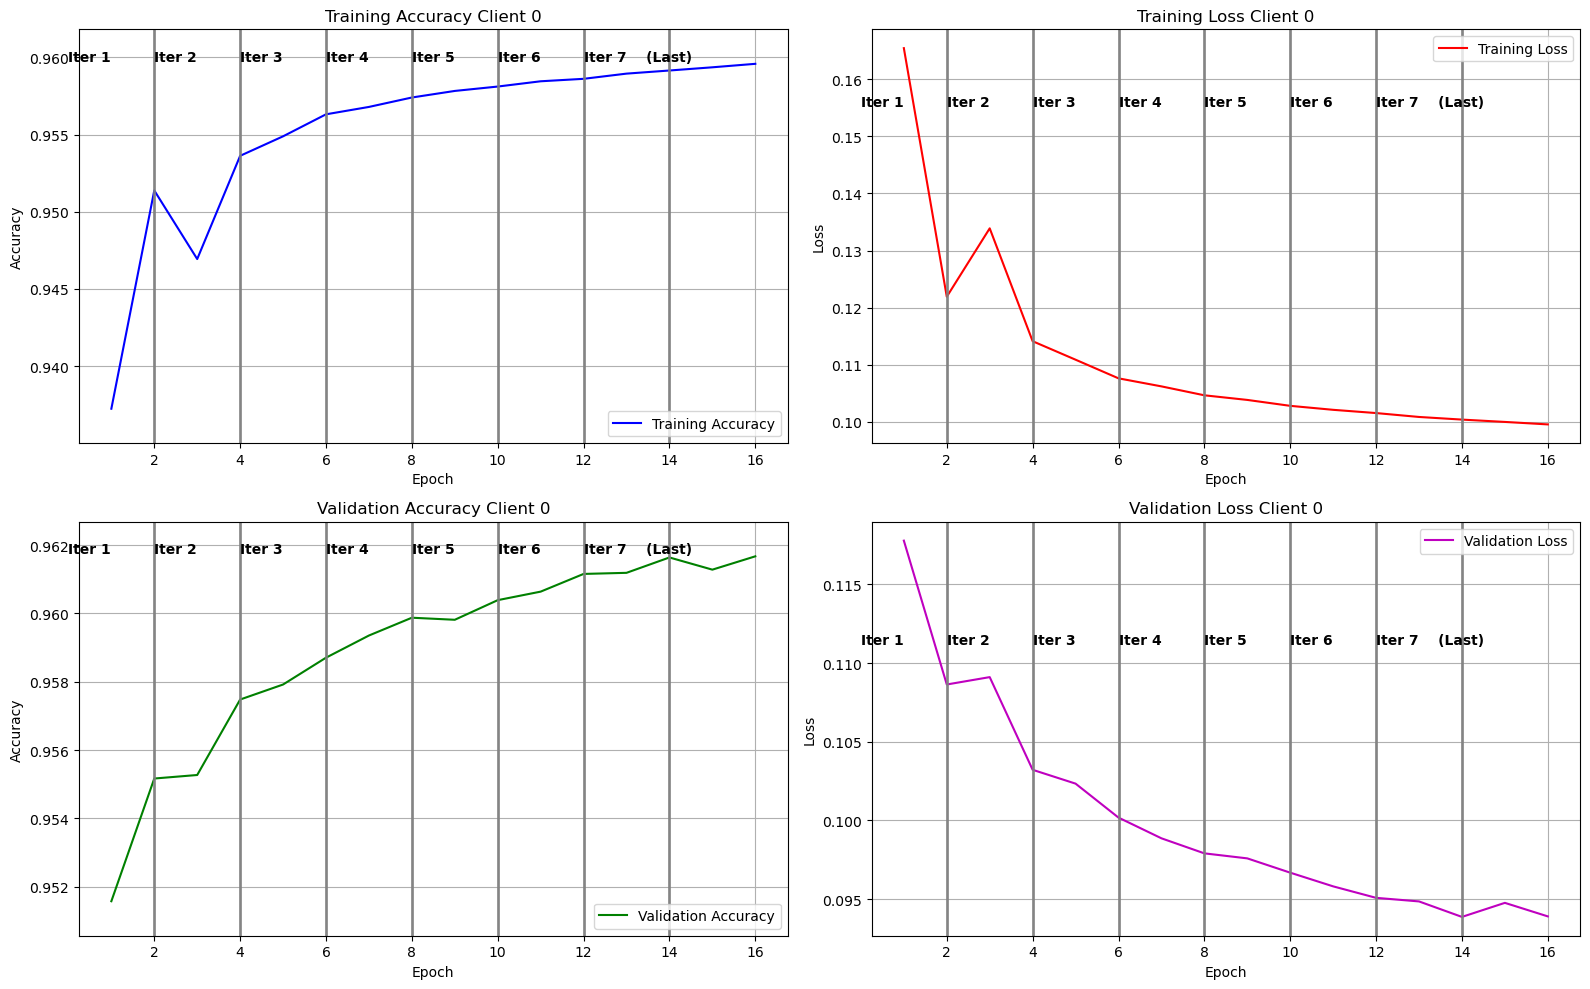

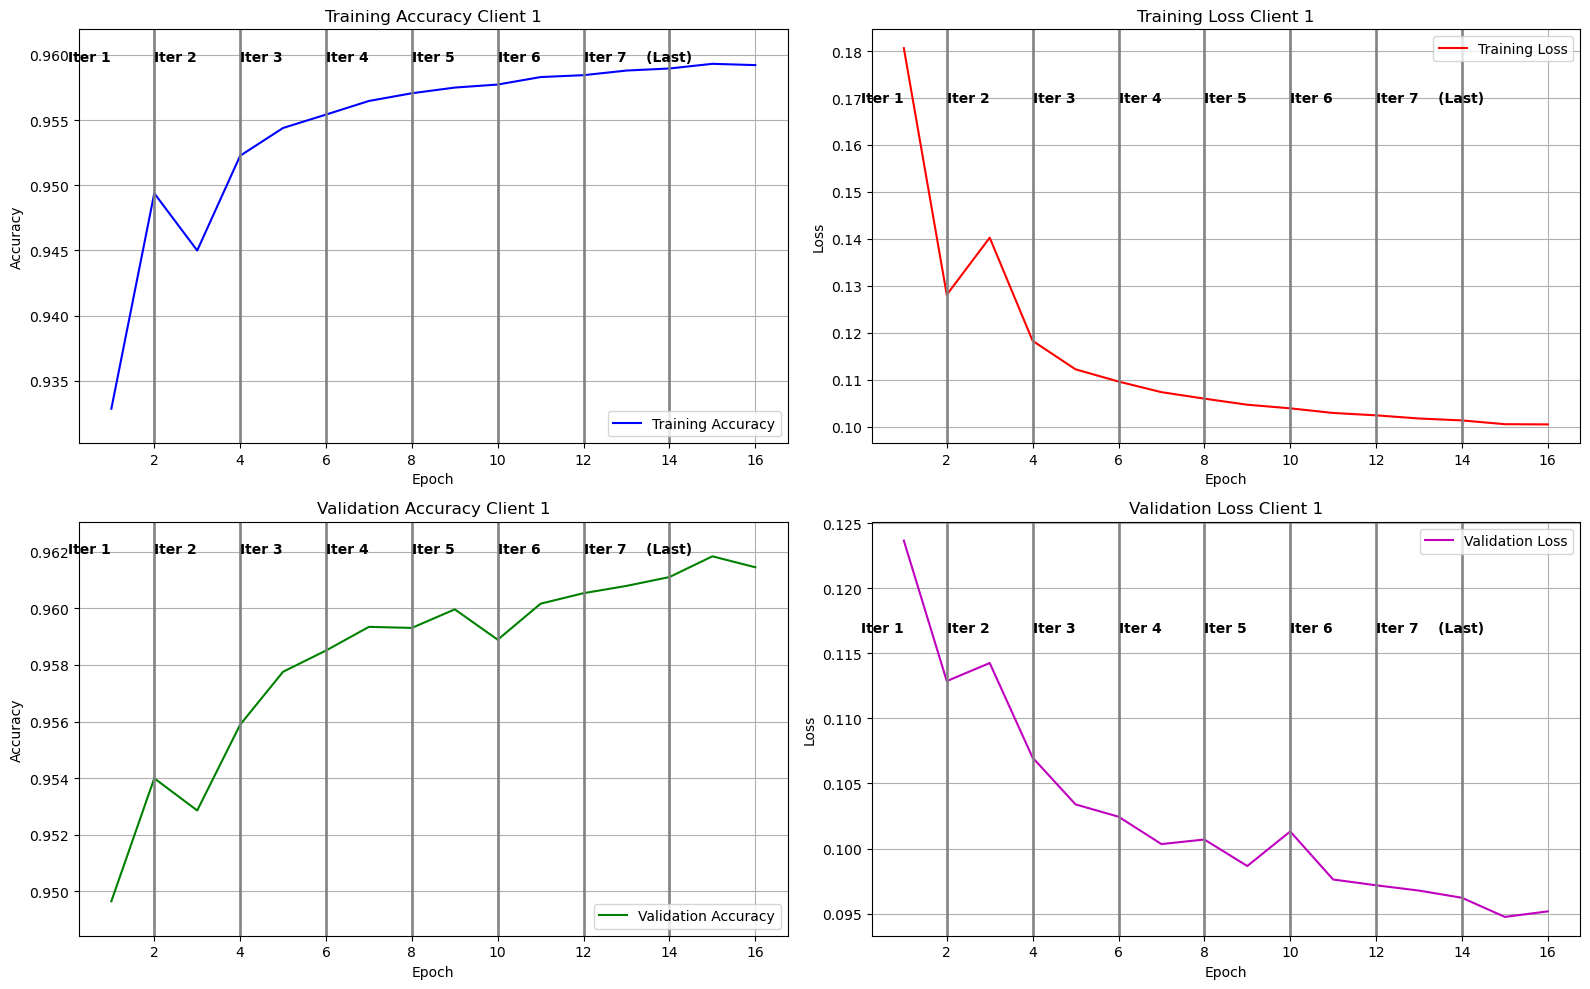

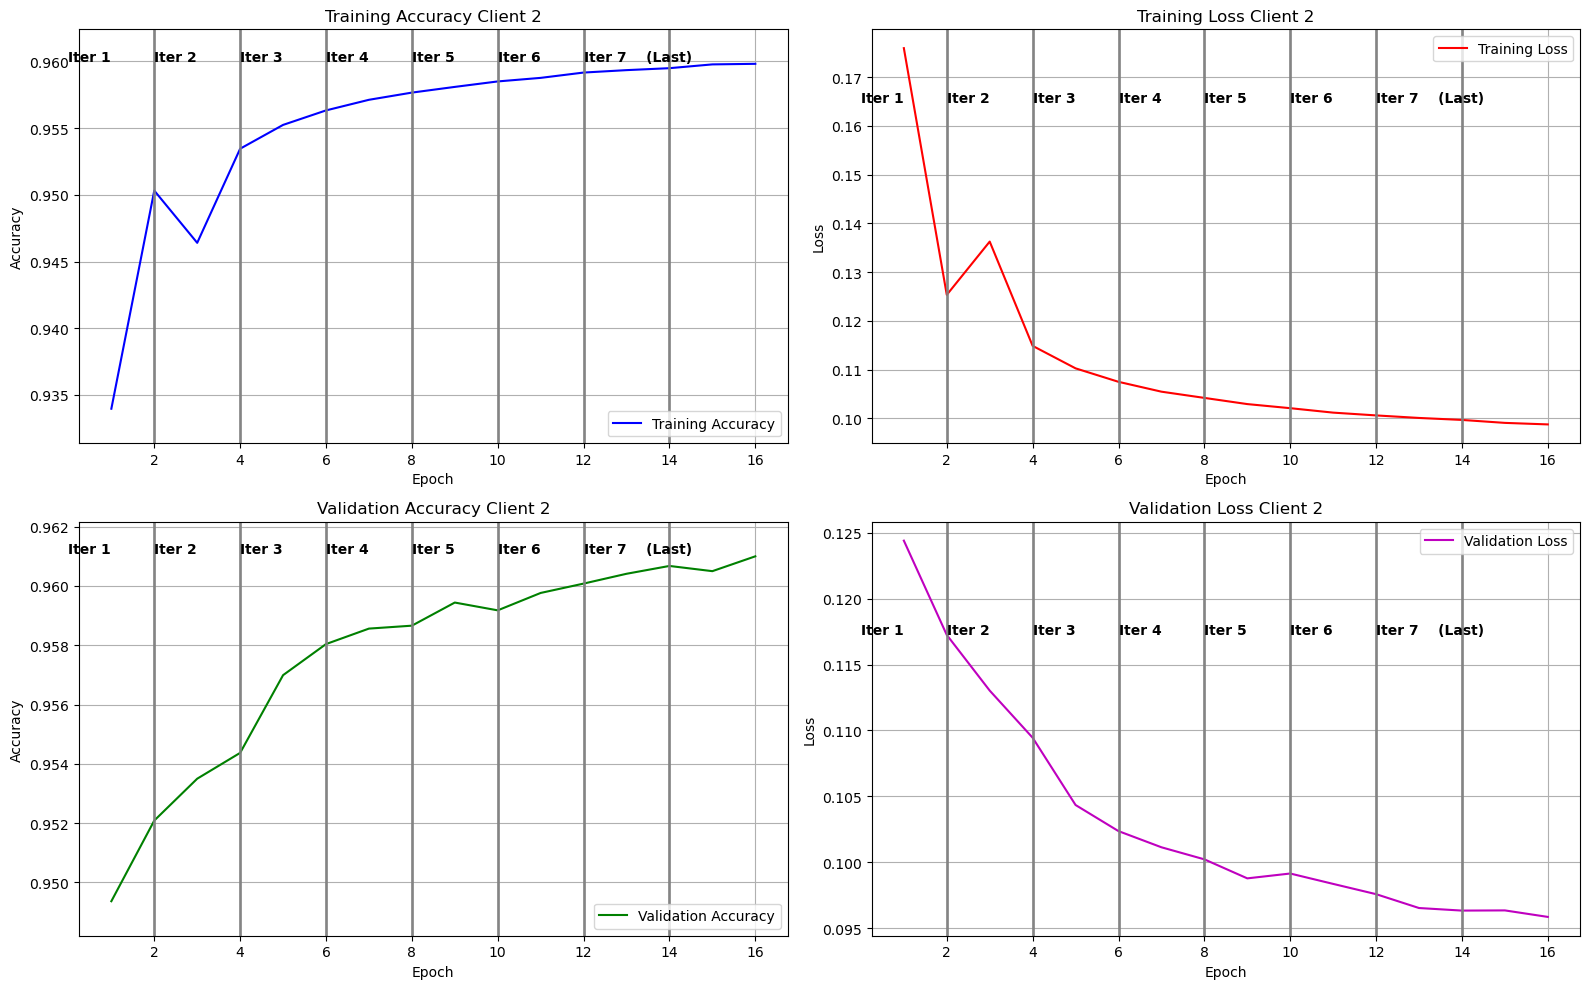

In [5]:
# Phần vẽ biểu đồ log (đã điều chỉnh để tự động tính số epoch)
log_names = {f'client_{i}': [f"Iteration_{j+1}.csv" for j in range(actual_iterations[f'client_{i}'])] for i in range(len(active_clients_list))}
print(f"Log files: {log_names}")

for i in range(len(active_clients_list)):
    all_logs = []
    for log_name in log_names[f'client_{i}']:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    if not all_logs:
        print(f"No log files found for client_{i}, skipping log plots.")
        continue

    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)
    total_epochs = len(log_df)
    epochs_per_iteration = total_epochs // actual_iterations[f'client_{i}']  # Tính số epoch trung bình mỗi iteration

    plt.figure(figsize=(16, 10))

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_acc = max(log_df['accuracy']) if not log_df['accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_val_acc = max(log_df['val_accuracy']) if not log_df['val_accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_val_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/train_valid_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

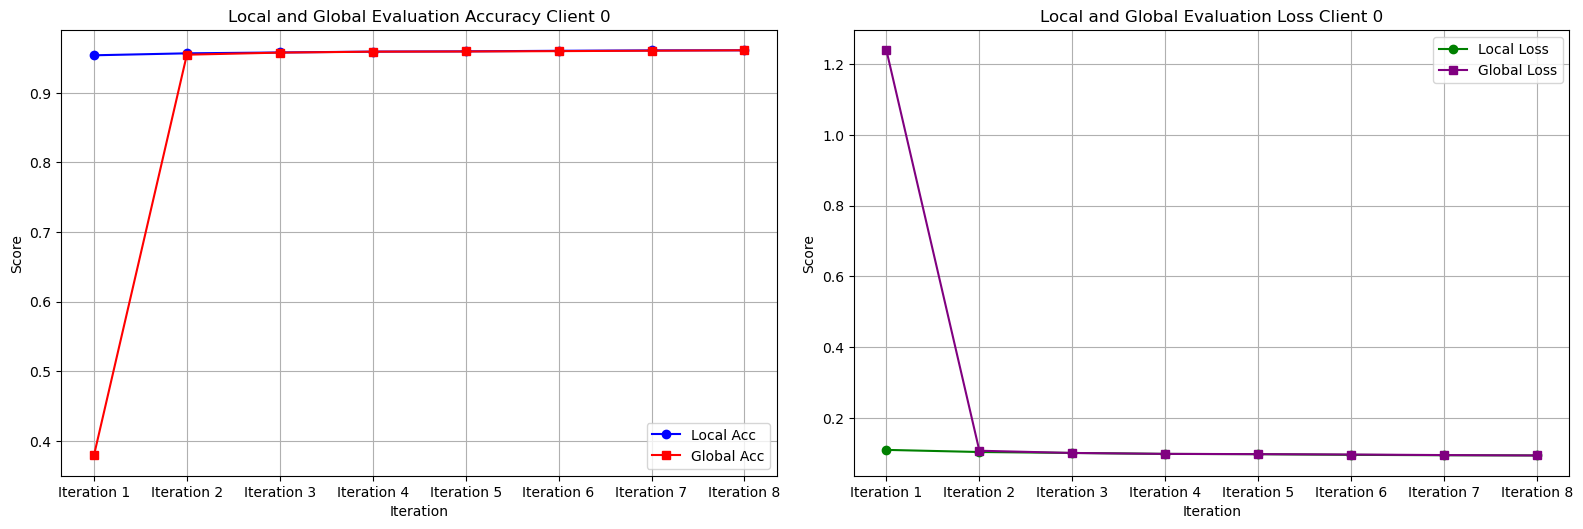

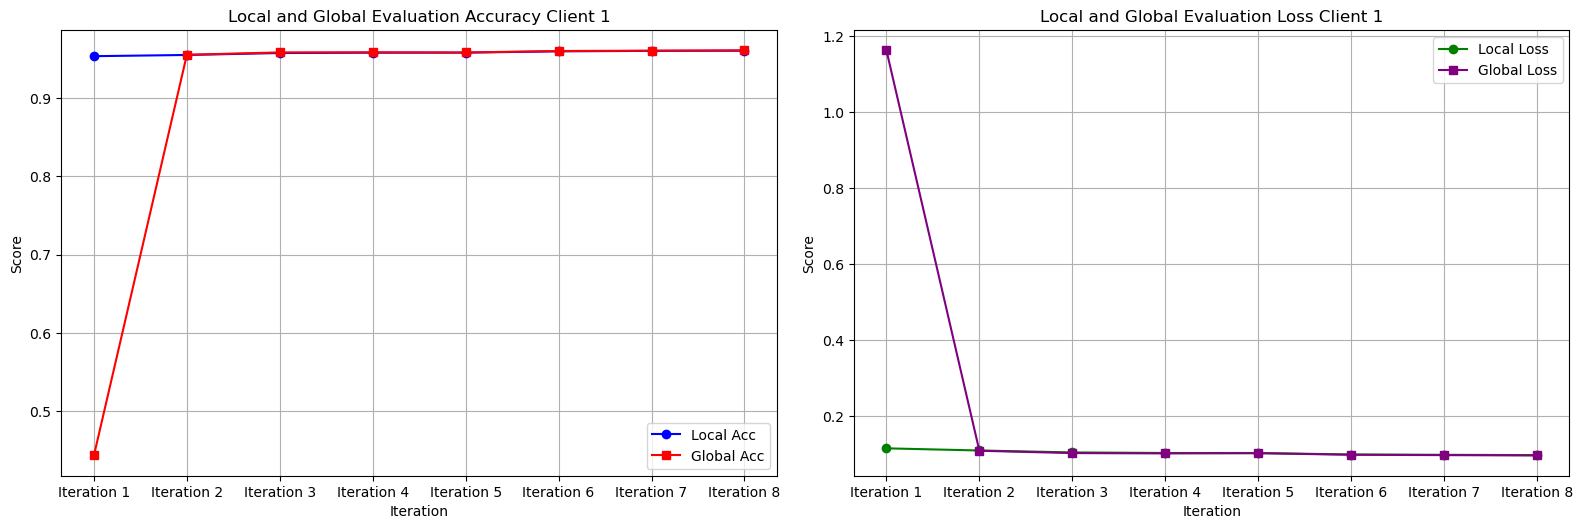

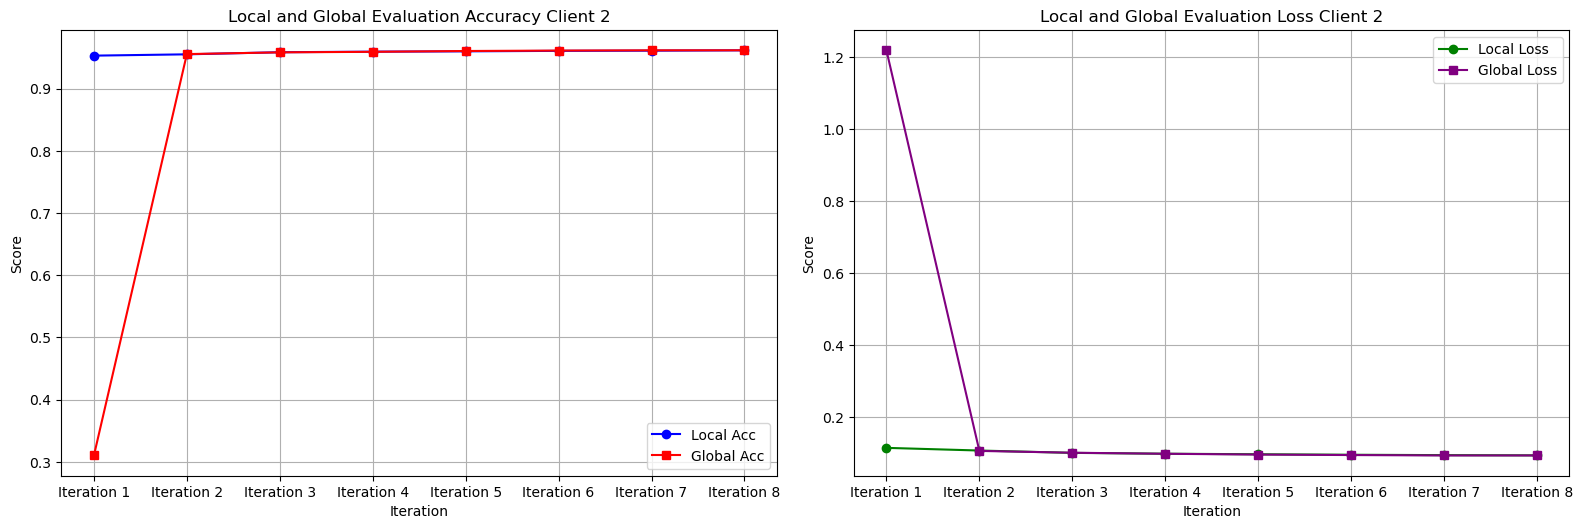

In [6]:
# Phần vẽ local/global evaluation
for i in range(len(active_clients_list)):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations[f'client_{i}'], local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations[f'client_{i}'], global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations[f'client_{i}'], local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations[f'client_{i}'], global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/evaluation_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

#Client 2

precisions = []
recalls = []
f1s = []

#Iterations = [f"Iteration {index+1}" for index in range(5)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.savefig(tempdirs[2]+ "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()


attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.savefig(tempdirs[2]+ "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ bảng
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 2", fontsize=12, pad=5)

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

## Chuẩn hóa dữ liệu (tính tỷ lệ phần trăm)
df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

# Vẽ biểu đồ cột chồng với sửa lỗi vị trí nhãn
fig, ax = plt.subplots(figsize=(18, 8))  # Tăng kích thước để có không gian hơn
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            # Đặt nhãn ở giữa phần hiện tại dựa trên bottom và height
            y_pos = bottom[i] + height / 2  # Căn giữa nhãn trong phần hiện tại
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,  # Chữ nằm ngang
                    fontsize=8, color="black")
    bottom += df_metrics[metric]  # Cập nhật bottom cho phần tiếp theo

ax.set_xlabel("Class", fontsize=8)
ax.set_ylabel("Percentage (%)", fontsize=8)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 2", fontsize=10, pad=5)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=8)
ax.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.15, 1))

plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[2]+ "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()